In [2]:
import pandas as pd
from datetime import datetime, timedelta

def convert_bjt_to_utc(input_file, output_file):
    # 读取CSV文件
    df = pd.read_csv(input_file)
    
    # 检查是否存在DateTime(BJT)列
    if 'DateTime(BJT)' not in df.columns:
        print("Error: 'DateTime(BJT)' column not found in the CSV file.")
        return
    
    # 定义转换函数
    def bjt_to_utc(bjt_time):
        try:
            # 将字符串转换为 datetime 对象
            dt = datetime.strptime(str(bjt_time), '%Y%m%d%H')
            # 减去 8 小时转换为 UTC
            dt_utc = dt - timedelta(hours=8)
            # 转换回字符串格式
            return dt_utc.strftime('%Y%m%d%H')
        except ValueError:
            print(f"Error parsing time: {bjt_time}")
            return None
    
    # 应用转换函数
    df['DateTime(UTC)'] = df['DateTime(BJT)'].apply(bjt_to_utc)
    
    # 删除原始的 DateTime(BJT) 列
    df.drop(columns=['DateTime(BJT)'], inplace=True)
    
    # 重命名新列
    df.rename(columns={'DateTime(UTC)': 'DateTime(UTC)'}, inplace=True)
    
    # 保存到新文件
    df.to_csv(output_file, index=False)
    print(f"File successfully saved to {output_file}")

# 使用示例
input_file = '/home/dl392/data/yiwei/typhoon/data_preprocess/best_track_records.csv'  # 输入文件名
output_file = '/home/dl392/data/yiwei/typhoon/data_preprocess/best_track_records.csv_p1.csv'  # 输出文件名
convert_bjt_to_utc(input_file, output_file)

File successfully saved to /home/dl392/data/yiwei/typhoon/data_preprocess/best_track_records.csv_p1.csv


In [3]:
import pandas as pd

# 输入文件名和输出文件名
input_file = "/home/dl392/data/yiwei/typhoon/data_preprocess/best_track_records.csv_p1.csv"  # 原始CSV文件
output_file = "/home/dl392/data/yiwei/typhoon/data_preprocess/best_track_records.csv_p2.csv"  # 处理后的CSV文件

# 读取CSV文件
df = pd.read_csv(input_file)

# 删除"Storm Name"列中值为"(nameless)"的行
filtered_df = df[df["Storm Name"] != "(nameless)"]

# 将处理后的数据保存到新文件
filtered_df.to_csv(output_file, index=False)

print(f"处理完成！已将结果保存")

处理完成！已将结果保存


In [4]:
import pandas as pd

# Load the uploaded CSV file
file_path = '/home/dl392/data/yiwei/typhoon/data_preprocess/best_track_records.csv_p2.csv'
storm_data = pd.read_csv(file_path)

# Display the first few rows to understand the structure
storm_data.head()

,Storm Name,Intensity Category,Latitude (°N),Longitude (°E),Pressure (hPa),Max Sustained Wind (m/s),DateTime(UTC)
0,Vernon,1,12.0,113.5,1003,12,1984060716
1,Vernon,1,12.5,112.9,1002,15,1984060722
2,Vernon,1,13.0,112.6,1002,15,1984060804
3,Vernon,1,13.5,112.4,999,15,1984060810
4,Vernon,1,14.0,112.3,999,15,1984060816


In [5]:
import json
from datetime import datetime

# Initialize a list to store the requests
requests_list = []

# Group by Storm Name to handle multiple DateTimes for each storm
storm_groups = storm_data.groupby("Storm Name")

# Process each storm
for storm_name, group in storm_groups:
    # Prepare to accumulate unique dates, months, and times
    year_set = set()
    month_set = set()
    day_set = set()
    time_set = set()
    
    # Prepare to calculate area bounds
    latitudes = group["Latitude (°N)"]
    longitudes = group["Longitude (°E)"]
    
    # Extract area bounds (min/max latitude/longitude with ±1 adjustment)
    area = [
        int(latitudes.max()) + 2,  # North
        int(longitudes.min()) - 2, # West
        int(latitudes.min()) - 2,  # South
        int(longitudes.max()) + 2  # East
    ]
    
    # Process datetime and gather all unique components
    for datetime_str in group["DateTime(UTC)"]:
        # Parse datetime
        dt = datetime.strptime(str(datetime_str), "%Y%m%d%H")
        year_set.add(str(dt.year))
        month_set.add(f"{dt.month:02}")
        day_set.add(f"{dt.day:02}")
        time_set.add(f"{dt.hour:02}:00")
    
    # Construct the request dictionary for the storm
    request = {
        "product_type": ["reanalysis"],
        "variable": [
            "sea_surface_temperature",
            "surface_pressure"
        ],
        "year": sorted(list(year_set)),
        "month": sorted(list(month_set)),
        "day": sorted(list(day_set)),
        "time": sorted(list(time_set)),
        "data_format": "grib",
        "download_format": "unarchived",
        "area": area
    }
    
    # Add to the list with the storm name as context
    requests_list.append({storm_name: request})

# Save the requests list to a JSON file
output_path = "/home/dl392/data/yiwei/typhoon/EAR5/storm_requests.json"
with open(output_path, "w") as json_file:
    json.dump(requests_list, json_file, indent=4)

output_path


'/home/dl392/data/yiwei/typhoon/EAR5/storm_requests.json'

In [6]:
import json
from datetime import datetime

# Initialize a dictionary to store the requests with Storm Name as keys
requests_dict = {}

# Group by Storm Name to handle multiple DateTimes for each storm
storm_groups = storm_data.groupby("Storm Name")

# Process each storm
for storm_name, group in storm_groups:
    # Prepare to accumulate unique dates, months, and times
    year_set = set()
    month_set = set()
    day_set = set()
    time_set = set()
    
    # Prepare to calculate area bounds
    latitudes = group["Latitude (°N)"]
    longitudes = group["Longitude (°E)"]
    
    # Extract area bounds (min/max latitude/longitude with ±1 adjustment)
    area = [
        int(latitudes.max()) + 2,  # North
        int(longitudes.min()) - 2, # West
        int(latitudes.min()) - 2,  # South
        int(longitudes.max()) + 2  # East
    ]
    
    # Process datetime and gather all unique components
    for datetime_str in group["DateTime(UTC)"]:
        # Parse datetime
        dt = datetime.strptime(str(datetime_str), "%Y%m%d%H")
        year_set.add(str(dt.year))
        month_set.add(f"{dt.month:02}")
        day_set.add(f"{dt.day:02}")
        time_set.add(f"{dt.hour:02}:00")
    
    # Construct the request dictionary for the storm
    request = {
        "product_type": ["reanalysis"],
        "variable": [
            "sea_surface_temperature",
            "surface_pressure"
        ],
        "year": sorted(list(year_set)),
        "month": sorted(list(month_set)),
        "day": sorted(list(day_set)),
        "time": sorted(list(time_set)),
        "data_format": "grib",
        "download_format": "unarchived",
        "area": area
    }
    
    # Add the request to the dictionary with Storm Name as the key
    requests_dict[storm_name] = request

# Save the requests dictionary to a JSON file
output_path = "/home/dl392/data/yiwei/typhoon/EAR5/storm_requests.json"
with open(output_path, "w") as json_file:
    json.dump(requests_dict, json_file, indent=4)

output_path


'/home/dl392/data/yiwei/typhoon/EAR5/storm_requests.json'

In [1]:
import pandas as pd

# 读取CSV文件
input_file = "/home/dl392/data/yiwei/typhoon/data_preprocess/best_track_records.csv_p2.csv"  # 替换为你的输入文件名
output_file = "/home/dl392/data/yiwei/typhoon/data_preprocess/best_track_records.csv_p3.csv"  # 替换为你的输出文件名

# 加载CSV文件到DataFrame
df = pd.read_csv(input_file)

# 确保列名匹配
if 'DateTime(UTC)' in df.columns:
    # 转换DateTime(UTC)为标准时间格式
    def convert_to_iso_format(dt):
        try:
            # 转换为字符串并解析
            dt_str = str(dt)
            year = dt_str[:4]
            month = dt_str[4:6]
            day = dt_str[6:8]
            hour = dt_str[8:]
            return f"{year}-{month}-{day}T{hour}"
        except:
            return None  # 处理格式错误的情况

    # 创建新列并存储转换结果
    df['ConvertedDateTime'] = df['DateTime(UTC)'].apply(convert_to_iso_format)

    # 保存到新的CSV文件
    df.to_csv(output_file, index=False)
    print(f"转换完成，结果已保存到 {output_file}")
else:
    print("输入文件中未找到 'DateTime(UTC)' 列")


转换完成，结果已保存到 /home/dl392/data/yiwei/typhoon/data_preprocess/best_track_records.csv_p3.csv


In [7]:
import json
file_path="/home/dl392/data/yiwei/typhoon/EAR5/storm_requests.json"
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)
data['Vernon']

{'product_type': ['reanalysis'],
 'variable': ['sea_surface_temperature', 'surface_pressure'],
 'year': ['1984'],
 'month': ['06'],
 'day': ['07', '08', '09', '10'],
 'time': ['04:00', '10:00', '16:00', '22:00'],
 'data_format': 'grib',
 'download_format': 'unarchived',
 'area': [19, 102, 10, 115]}

In [ ]:
import pandas as pd
import json
import cdsapi
import xarray as xr

# 配置路径和参数
csv_file = "/home/dl392/data/yiwei/typhoon/data_preprocess/best_track_records.csv_p3.csv"
json_file = "/home/dl392/data/yiwei/typhoon/EAR5/storm_requests.json"
output_csv = "/home/dl392/data/yiwei/typhoon/data_preprocess/best_track_records.csv_p4.csv"
DATADIR = '/home/dl392/data/yiwei/typhoon/EAR5/'
dataset = "reanalysis-era5-single-levels"
URL = 'https://cds-beta.climate.copernicus.eu/api'
KEY = '0d9a33a4-3541-4c92-ac8e-b8314c2ee0f4'

# 初始化 CDSAPI 客户端
client = cdsapi.Client(url=URL, key=KEY)

# 读取 CSV 和 JSON 文件
df = pd.read_csv(csv_file)
with open(json_file, 'r') as f:
    requests_data = json.load(f)

# 初始化已处理的 Storm Name 集合
processed_storms = set()

# 新增列
df['sst'] = None
df['sp'] = None

# 遍历 CSV
for index, row in df.iterrows():
    storm_name = row['Storm Name']
    latitude = row['Latitude (°N)']
    longitude = row['Longitude (°E)']
    time = row['ConvertedDateTime']
    
    # 如果是第一次遇到该 Storm Name
    if storm_name not in processed_storms:
        # 获取对应的 request 数据
        if storm_name not in requests_data:
            print(f"Warning: Storm Name {storm_name} not found in JSON file.")
            continue
        
        request = requests_data[storm_name]
        
        # 下载 ERA5 数据
        try:
            client.retrieve(dataset, request, f'{DATADIR}temp.grib')
        except Exception as e:
            print(f"Error retrieving data for {storm_name}: {e}")
            continue

        # 标记为已处理
        processed_storms.add(storm_name)

    # 加载 GRIB 数据
    try:
        ds = xr.open_dataset(f"{DATADIR}temp.grib", engine="cfgrib")
    except Exception as e:
        print(f"Error opening GRIB file: {e}")
        continue

    # 提取 sst 和 sp
    try:
        sst = ds['sst'].sel(time=time, latitude=latitude, longitude=longitude, method="nearest").values
        sp = ds['sp'].sel(time=time, latitude=latitude, longitude=longitude, method="nearest").values
        
    except Exception as e:
        print(f"Error selecting data for {storm_name} at index {index}: {e}")
        continue

    # 保存到新的列
    df.at[index, 'sst'] = sst
    df.at[index, 'sp'] = sp
    print(storm_name, "finished")

# 保存更新后的 CSV
df.to_csv(output_csv, index=False)
print(f"Updated CSV saved to {output_csv}")


2024-11-19 09:17:05,810 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-19 09:17:05,812 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-19 09:17:05,813 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-19 09:17:05,813 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

In [12]:
(300.38013+299.0979)/2

299.739015

In [16]:
import pandas as pd
import json
import cdsapi
import xarray as xr
import numpy as np

# 配置路径和参数

sst_output_json = "sst_data_matrix.json"
sp_output_json = "sp_data_matrix.json"
csv_file = "/home/dl392/data/yiwei/typhoon/data_preprocess/best_track_records.csv_p5.csv"
json_file = "/home/dl392/data/yiwei/typhoon/EAR5/storm_requests.json"

DATADIR = '/home/dl392/data/yiwei/typhoon/EAR5/'
dataset = "reanalysis-era5-single-levels"
URL = 'https://cds-beta.climate.copernicus.eu/api'
KEY = 'your key'

# 初始化 CDSAPI 客户端
client = cdsapi.Client(url=URL, key=KEY)

# 读取 CSV 和 JSON 文件
df = pd.read_csv(csv_file)
with open(json_file, 'r') as f:
    requests_data = json.load(f)

# 初始化已处理的 Storm Name 集合
processed_storms = set()

# 存储 sst 和 sp 数据
sst_data = {}
sp_data = {}

# 遍历 CSV
for index, row in df.iterrows():
    storm_name = row['Storm Name']
    print("Processing ", storm_name)

    latitude = row['Latitude (°N)']
    longitude = row['Longitude (°E)']
    time = row['ConvertedDateTime']
    UTC_time=row['DateTime(UTC)']
    # 如果是第一次遇到该 Storm Name
    if storm_name not in processed_storms:
        # 获取对应的 request 数据
        if storm_name not in requests_data:
            print(f"Warning: Storm Name {storm_name} not found in JSON file.")
            continue
        
        request = requests_data[storm_name]
        
        # 下载 ERA5 数据
        try:
            client.retrieve(dataset, request, f'{DATADIR}temp.grib')
        except Exception as e:
            print(f"Error retrieving data for {storm_name}: {e}")
            continue

        # 标记为已处理
        processed_storms.add(storm_name)

    # 加载 GRIB 数据
    try:
        ds = xr.open_dataset(f"{DATADIR}temp.grib", engine="cfgrib")
    except Exception as e:
        print(f"Error opening GRIB file: {e}")
        continue

    # 生成网格
    latitudes=[]
    longitudes=[]
    for i in range(-10,11, 1):
        latitudes.append(latitude+i/10)
        longitudes.append(longitude+i/10)
    # latitudes = np.arange(latitude - 1, latitude + 1.1, 0.1)  # 纬度范围
    # longitudes = np.arange(longitude - 1, longitude + 1.1, 0.1)  # 经度范围

    sst_grid = []
    sp_grid = []

    for lat in latitudes:
        sst_row = []
        sp_row = []
        for lon in longitudes:
            try:
                sst_value = round(float(ds['sst'].sel(time=time, latitude=lat, longitude=lon, method="nearest").values),5)
                sp_value = round(float(ds['sp'].sel(time=time, latitude=lat, longitude=lon, method="nearest").values),5)
            except Exception as e:
                print(f"Error selecting data for {storm_name} at lat {lat}, lon {lon}: {e}")
                sst_value = None
                sp_value = None

            sst_row.append(sst_value)
            sp_row.append(sp_value)
        
        sst_grid.append(sst_row)
        sp_grid.append(sp_row)
    store_name=str(storm_name)+str(UTC_time)
    # 保存到对应的字典
    sst_data[store_name] = {
        "time": time,
        "latitude_range": list(latitudes),
        "longitude_range": list(longitudes),
        "sst_grid": sst_grid
    }

    sp_data[store_name] = {
        "time": time,
        "latitude_range": list(latitudes),
        "longitude_range": list(longitudes),
        "sp_grid": sp_grid
    }
    print(storm_name, " is finished")
    
# 保存到 JSON 文件
with open(sst_output_json, 'w') as f:
    json.dump(sst_data, f, indent=4)

with open(sp_output_json, 'w') as f:
    json.dump(sp_data, f, indent=4)

print(f"SST data saved to {sst_output_json}")
print(f"SP data saved to {sp_output_json}")


2024-11-24 01:58:59,876 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-24 01:58:59,878 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-24 01:58:59,879 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-24 01:58:59,881 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

Processing  Vernon


2024-11-24 01:59:00,920 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 01:59:00,922 INFO Request ID is 0aeb859a-d8a4-4bc6-ac1a-d9ad096f9419
2024-11-24 01:59:01,192 INFO status has been updated to accepted
2024-11-24 01:59:05,532 INFO status has been updated to running
2024-11-24 01:59:08,021 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Vernon  is finished
Processing  Vernon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Vernon  is finished
Processing  Vernon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Vernon  is finished
Processing  Vernon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Vernon  is finished
Processing  Vernon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Vernon  is finished
Processing  Vernon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Vernon  is finished
Processing  Vernon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Vernon  is finished
Processing  Vernon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Vernon  is finished
Processing  Vernon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Vernon  is finished
Processing  Vernon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Vernon  is finished
Processing  Vernon
Vernon  is finished
Processing  Ophelia


2024-11-24 01:59:32,107 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 01:59:32,108 INFO Request ID is 28f58f58-c467-45de-8110-f84cf54fc099
2024-11-24 01:59:32,340 INFO status has been updated to accepted
2024-11-24 01:59:35,332 INFO status has been updated to running
2024-11-24 01:59:37,804 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ophelia  is finished
Processing  Ophelia
Ophelia  is finished
Processing  Irma


2024-11-24 02:01:17,727 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:01:17,728 INFO Request ID is f5e2ff2b-7b26-40be-ba7c-525abacbb275
2024-11-24 02:01:20,042 INFO status has been updated to accepted
2024-11-24 02:01:21,845 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma
Irma  is finished
Processing  Wanda


2024-11-24 02:02:33,698 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:02:33,699 INFO Request ID is 2f968671-7d7c-4142-a44f-43d246375c70
2024-11-24 02:02:33,910 INFO status has been updated to accepted
2024-11-24 02:02:39,584 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Wanda  is finished
Processing  Wanda
Wanda  is finished
Processing  Kujira


2024-11-24 02:03:21,192 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:03:21,194 INFO Request ID is 4634146a-df21-4d2b-b8b7-8f8a2555baf7
2024-11-24 02:03:21,920 INFO status has been updated to accepted
2024-11-24 02:03:25,567 INFO status has been updated to running
2024-11-24 02:03:29,734 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kujira  is finished
Processing  Kujira
Kujira  is finished
Processing  Yanyan


2024-11-24 02:04:25,973 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:04:25,975 INFO Request ID is 8b5c1800-f568-4857-b591-c5d00c66c984
2024-11-24 02:04:26,964 INFO status has been updated to accepted
2024-11-24 02:04:32,235 INFO status has been updated to running
2024-11-24 02:04:34,698 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Yanyan  is finished
Processing  Yanyan
Yanyan  is finished
Processing  Ivy


2024-11-24 02:05:24,882 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:05:24,884 INFO Request ID is a994bf49-7eac-4e77-9df2-055953e7c8b5
2024-11-24 02:05:25,104 INFO status has been updated to accepted
2024-11-24 02:05:28,023 INFO status has been updated to running
2024-11-24 02:05:31,488 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ivy  is finished
Processing  Ivy
Ivy  is finished
Processing  Nadine


2024-11-24 02:06:34,363 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:06:34,365 INFO Request ID is 246c1ef6-d1bd-43bc-bb20-9af75477f304
2024-11-24 02:06:34,640 INFO status has been updated to accepted
2024-11-24 02:06:44,166 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nadine  is finished
Processing  Nadine
Nadine  is finished
Processing  Carmen


2024-11-24 02:07:42,165 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:07:42,167 INFO Request ID is 940898d1-4594-4773-8ef1-eea55a9ff772
2024-11-24 02:07:44,171 INFO status has been updated to accepted
2024-11-24 02:07:45,423 INFO status has been updated to running
2024-11-24 02:07:47,982 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Carmen  is finished
Processing  Carmen
Carmen  is finished
Processing  Violet


2024-11-24 02:09:30,191 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:09:30,193 INFO Request ID is d7f586a6-1ed3-4595-98ba-90cde9d43eb7
2024-11-24 02:09:30,513 INFO status has been updated to accepted
2024-11-24 02:09:33,451 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Violet  is finished
Processing  Violet
Violet  is finished
Processing  Kit


2024-11-24 02:10:43,581 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:10:43,583 INFO Request ID is f245a3de-e099-4946-a91a-2549afe63e76
2024-11-24 02:10:43,792 INFO status has been updated to accepted
2024-11-24 02:10:46,723 INFO status has been updated to running
2024-11-24 02:10:50,035 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kit  is finished
Processing  Kit
Kit  is finished
Processing  BOLAVEN


2024-11-24 02:12:04,252 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:12:04,254 INFO Request ID is 1d8be001-8b43-4633-8c33-f22592cccde6
2024-11-24 02:12:04,505 INFO status has been updated to accepted
2024-11-24 02:12:07,572 INFO status has been updated to running
2024-11-24 02:12:10,080 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


BOLAVEN  is finished
Processing  BOLAVEN
BOLAVEN  is finished
Processing  Fabian


2024-11-24 02:12:52,961 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:12:52,962 INFO Request ID is c0c5f6eb-99a0-404a-ad06-8542aa804298
2024-11-24 02:12:53,165 INFO status has been updated to accepted
2024-11-24 02:12:59,261 INFO status has been updated to running
2024-11-24 02:13:03,053 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fabian  is finished
Processing  Fabian
Fabian  is finished
Processing  IRIS


2024-11-24 02:14:22,530 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:14:22,531 INFO Request ID is 3a1e3558-0fd1-4996-84ed-230d3c421d20
2024-11-24 02:14:22,902 INFO status has been updated to accepted
2024-11-24 02:14:28,712 INFO status has been updated to running
2024-11-24 02:14:32,550 INFO status has been updated to accepted
2024-11-24 02:14:57,414 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


IRIS  is finished
Processing  IRIS


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


IRIS  is finished
Processing  IRIS


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


IRIS  is finished
Processing  IRIS


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


IRIS  is finished
Processing  IRIS


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


IRIS  is finished
Processing  IRIS


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


IRIS  is finished
Processing  IRIS


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


IRIS  is finished
Processing  IRIS


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


IRIS  is finished
Processing  IRIS


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


IRIS  is finished
Processing  IRIS
IRIS  is finished
Processing  Tapah


2024-11-24 02:15:18,702 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:15:18,704 INFO Request ID is 6dc23fe9-e4e3-4fcb-9063-ac5da83f7998
2024-11-24 02:15:18,914 INFO status has been updated to accepted
2024-11-24 02:15:21,905 INFO status has been updated to running
2024-11-24 02:15:33,608 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tapah  is finished
Processing  Tapah
Tapah  is finished
Processing  Chuck


2024-11-24 02:16:06,172 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:16:06,174 INFO Request ID is 20de59c2-88a6-4dd6-90f4-69ebf3c1fa31
2024-11-24 02:16:08,003 INFO status has been updated to accepted
2024-11-24 02:16:09,228 INFO status has been updated to running
2024-11-24 02:16:10,936 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Chuck  is finished
Processing  Chuck
Chuck  is finished
Processing  Mamie


2024-11-24 02:17:08,781 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:17:08,783 INFO Request ID is fe3ec217-fac1-46ea-b602-bd4d7ca8e240
2024-11-24 02:17:09,056 INFO status has been updated to accepted
2024-11-24 02:17:11,180 INFO status has been updated to running
2024-11-24 02:17:12,951 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mamie  is finished
Processing  Mamie
Mamie  is finished
Processing  Damrey


2024-11-24 02:18:37,594 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:18:37,595 INFO Request ID is 1cbe98f0-cbed-4c85-9695-66a039f034f8
2024-11-24 02:18:38,115 INFO status has been updated to accepted
2024-11-24 02:18:44,338 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Damrey  is finished
Processing  Damrey
Damrey  is finished
Processing  Roy


2024-11-24 02:19:46,879 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:19:46,881 INFO Request ID is 88cf6339-93b3-4978-9db2-83c7eb6ebdea
2024-11-24 02:19:47,108 INFO status has been updated to accepted
2024-11-24 02:19:53,321 INFO status has been updated to running
2024-11-24 02:19:58,180 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Roy  is finished
Processing  Roy
Roy  is finished
Processing  Winona


2024-11-24 02:21:26,250 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:21:26,252 INFO Request ID is c9cc6045-90a8-4fff-8830-b5e14179e992
2024-11-24 02:21:27,977 INFO status has been updated to accepted
2024-11-24 02:21:30,959 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Winona  is finished
Processing  Winona


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Winona  is finished
Processing  Winona


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Winona  is finished
Processing  Winona


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Winona  is finished
Processing  Winona


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Winona  is finished
Processing  Winona


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Winona  is finished
Processing  Winona


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Winona  is finished
Processing  Winona


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Winona  is finished
Processing  Winona


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Winona  is finished
Processing  Winona


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Winona  is finished
Processing  Winona


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Winona  is finished
Processing  Winona


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Winona  is finished
Processing  Winona


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Winona  is finished
Processing  Winona
Winona  is finished
Processing  NICHOLE


2024-11-24 02:22:01,155 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:22:01,157 INFO Request ID is b54d26d2-3e96-4694-8be8-72fdc030042c
2024-11-24 02:22:01,399 INFO status has been updated to accepted
2024-11-24 02:22:18,354 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


NICHOLE  is finished
Processing  NICHOLE


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


NICHOLE  is finished
Processing  NICHOLE


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


NICHOLE  is finished
Processing  NICHOLE


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


NICHOLE  is finished
Processing  NICHOLE


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


NICHOLE  is finished
Processing  NICHOLE


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


NICHOLE  is finished
Processing  NICHOLE


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


NICHOLE  is finished
Processing  NICHOLE


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


NICHOLE  is finished
Processing  NICHOLE


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


NICHOLE  is finished
Processing  NICHOLE


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


NICHOLE  is finished
Processing  NICHOLE


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


NICHOLE  is finished
Processing  NICHOLE


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


NICHOLE  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Irma  is finished
Processing  Irma
Irma  is finished
Processing  Rita


2024-11-24 02:23:44,669 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:23:44,670 INFO Request ID is c375ef7e-b035-4a0d-93c3-6eefd61a9ae7
2024-11-24 02:23:44,872 INFO status has been updated to accepted
2024-11-24 02:23:50,355 INFO status has been updated to running
2024-11-24 02:23:59,222 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Rita  is finished
Processing  Rita
Rita  is finished
Processing  Judy


2024-11-24 02:24:55,437 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:24:55,439 INFO Request ID is 05d76ab8-f9dc-427e-a1e2-e2355ae8ec46
2024-11-24 02:24:55,730 INFO status has been updated to accepted
2024-11-24 02:25:08,740 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Judy  is finished
Processing  Judy
Judy  is finished
Processing  Sonamu


2024-11-24 02:26:05,854 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:26:05,856 INFO Request ID is 93b170fa-c4d7-41bd-8d4b-f2c5855efd1e
2024-11-24 02:26:06,443 INFO status has been updated to accepted
2024-11-24 02:26:16,308 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sonamu  is finished
Processing  Sonamu
Sonamu  is finished
Processing  Koryn


2024-11-24 02:27:38,381 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:27:38,384 INFO Request ID is 9cfebe9a-9a32-4818-8d85-fd8a67c4e2a0
2024-11-24 02:27:38,651 INFO status has been updated to accepted
2024-11-24 02:27:45,901 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Koryn  is finished
Processing  Koryn
Koryn  is finished
Processing  Georgia


2024-11-24 02:28:38,079 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:28:38,081 INFO Request ID is 797906a1-6c57-4f43-868b-5e30f7c26bfe
2024-11-24 02:28:38,301 INFO status has been updated to accepted
2024-11-24 02:28:44,260 INFO status has been updated to running
2024-11-24 02:28:47,861 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Georgia  is finished
Processing  Georgia
Georgia  is finished
Processing  Tess


2024-11-24 02:30:03,072 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:30:03,074 INFO Request ID is 330d09f7-7efa-492e-9c15-18fea3a56734
2024-11-24 02:30:04,584 INFO status has been updated to accepted
2024-11-24 02:30:10,116 INFO status has been updated to running
2024-11-24 02:30:15,538 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Tess  is finished
Processing  Tess
Tess  is finished
Processing  Malakas


2024-11-24 02:32:27,820 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:32:27,822 INFO Request ID is b2478247-c460-4d29-8dde-9672fd18da81
2024-11-24 02:32:28,800 INFO status has been updated to accepted
2024-11-24 02:32:31,836 INFO status has been updated to running
2024-11-24 02:32:38,825 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Malakas  is finished
Processing  Malakas
Malakas  is finished
Processing  Kathy


2024-11-24 02:34:36,123 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:34:36,125 INFO Request ID is 998dad5f-1edb-42a3-b24f-5b242c15c50c
2024-11-24 02:34:36,332 INFO status has been updated to accepted
2024-11-24 02:34:45,452 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kathy  is finished
Processing  Kathy
Kathy  is finished
Processing  Nancy


2024-11-24 02:35:35,422 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:35:35,423 INFO Request ID is df0c8d84-c18a-4150-8990-bae6880333a6
2024-11-24 02:35:35,639 INFO status has been updated to accepted
2024-11-24 02:35:44,664 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Nancy  is finished
Processing  Nancy
Nancy  is finished
Processing  HANNAH


2024-11-24 02:37:01,504 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:37:01,506 INFO Request ID is 99348cbd-1683-463d-aba7-8bb316dc00b1
2024-11-24 02:37:01,731 INFO status has been updated to accepted
2024-11-24 02:37:07,536 INFO status has been updated to running
2024-11-24 02:37:14,717 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


HANNAH  is finished
Processing  HANNAH


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


HANNAH  is finished
Processing  HANNAH


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


HANNAH  is finished
Processing  HANNAH


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


HANNAH  is finished
Processing  HANNAH


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


HANNAH  is finished
Processing  HANNAH


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


HANNAH  is finished
Processing  HANNAH


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


HANNAH  is finished
Processing  HANNAH


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


HANNAH  is finished
Processing  HANNAH
HANNAH  is finished
Processing  PABUK


2024-11-24 02:37:37,680 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:37:37,681 INFO Request ID is 9463be9a-20b4-400f-8102-7a40d0b2bdae
2024-11-24 02:37:38,373 INFO status has been updated to accepted
2024-11-24 02:37:44,532 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


PABUK  is finished
Processing  PABUK
PABUK  is finished
Processing  Cimaron


2024-11-24 02:38:21,606 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:38:21,607 INFO Request ID is a282c6b0-dd93-49d4-90ec-ded0f5185f4d
2024-11-24 02:38:21,823 INFO status has been updated to accepted
2024-11-24 02:38:25,345 INFO status has been updated to running
2024-11-24 02:38:27,804 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Cimaron  is finished
Processing  Cimaron
Cimaron  is finished
Processing  Sharon


2024-11-24 02:39:19,809 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:39:19,811 INFO Request ID is e988b456-42f8-4058-8868-a7db387159ab
2024-11-24 02:39:20,049 INFO status has been updated to accepted
2024-11-24 02:39:26,458 INFO status has been updated to running
2024-11-24 02:39:35,573 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sharon  is finished
Processing  Sharon
Sharon  is finished
Processing  Kong-rey


2024-11-24 02:40:47,696 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:40:47,698 INFO Request ID is 5896b3d0-a868-43fe-b997-13d8c5dea643
2024-11-24 02:40:47,939 INFO status has been updated to accepted
2024-11-24 02:40:53,826 INFO status has been updated to running
2024-11-24 02:40:57,557 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kong-rey  is finished
Processing  Kong-rey
Kong-rey  is finished
Processing  Ruby


2024-11-24 02:41:54,955 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:41:54,957 INFO Request ID is 61b66b9a-12d6-4b96-b2ee-d1b2e006e8c3
2024-11-24 02:41:55,194 INFO status has been updated to accepted
2024-11-24 02:42:00,688 INFO status has been updated to running
2024-11-24 02:42:04,288 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ruby  is finished
Processing  Ruby


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ruby  is finished
Processing  Ruby


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ruby  is finished
Processing  Ruby


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ruby  is finished
Processing  Ruby


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ruby  is finished
Processing  Ruby


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ruby  is finished
Processing  Ruby


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ruby  is finished
Processing  Ruby


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ruby  is finished
Processing  Ruby


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ruby  is finished
Processing  Ruby


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ruby  is finished
Processing  Ruby


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Ruby  is finished
Processing  Ruby
Ruby  is finished
Processing  Freda


2024-11-24 02:42:29,488 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:42:29,489 INFO Request ID is 0d544fb6-d2f1-45a2-80ad-893360059f5d
2024-11-24 02:42:29,789 INFO status has been updated to accepted
2024-11-24 02:42:35,368 INFO status has been updated to running
2024-11-24 02:42:44,334 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Freda  is finished
Processing  Freda
Freda  is finished
Processing  Charlotte


2024-11-24 02:43:38,470 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:43:38,472 INFO Request ID is 86cd8935-b815-4ec9-9042-5c5ac80370db
2024-11-24 02:43:39,507 INFO status has been updated to accepted
2024-11-24 02:43:48,601 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Charlotte  is finished
Processing  Charlotte
Charlotte  is finished
Processing  Phyllis


2024-11-24 02:44:20,020 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:44:20,022 INFO Request ID is 4de178e2-21b3-4036-b49a-3d850257b91c
2024-11-24 02:44:20,286 INFO status has been updated to accepted
2024-11-24 02:44:26,617 INFO status has been updated to running
2024-11-24 02:44:32,347 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Phyllis  is finished
Processing  Phyllis
Phyllis  is finished
Processing  Sarah


2024-11-24 02:45:47,119 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:45:47,121 INFO Request ID is 22a76234-6130-48a5-a34c-98024cc2944e
2024-11-24 02:45:47,335 INFO status has been updated to accepted
2024-11-24 02:45:52,848 INFO status has been updated to running
2024-11-24 02:45:59,172 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah
Sarah  is finished
Processing  Alice


2024-11-24 02:46:36,904 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:46:36,906 INFO Request ID is 4385eb34-2b7e-47c8-80a1-7add162a896a
2024-11-24 02:46:37,181 INFO status has been updated to accepted
2024-11-24 02:46:43,273 INFO status has been updated to running
2024-11-24 02:46:52,224 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Alice  is finished
Processing  Alice
Alice  is finished
Processing  Lingling


2024-11-24 02:49:27,013 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:49:27,016 INFO Request ID is f7521271-5803-458c-974c-8dc59e0e60cf
2024-11-24 02:49:27,267 INFO status has been updated to accepted
2024-11-24 02:49:31,269 INFO status has been updated to running
2024-11-24 02:49:37,436 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lingling  is finished
Processing  Lingling


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lingling  is finished
Processing  Lingling


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lingling  is finished
Processing  Lingling


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lingling  is finished
Processing  Lingling


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lingling  is finished
Processing  Lingling


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lingling  is finished
Processing  Lingling


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lingling  is finished
Processing  Lingling


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lingling  is finished
Processing  Lingling


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lingling  is finished
Processing  Lingling
Lingling  is finished
Processing  Owen


2024-11-24 02:49:59,328 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:49:59,329 INFO Request ID is 77836318-1a9a-42b8-9406-06c7714e5d40
2024-11-24 02:50:00,744 INFO status has been updated to accepted
2024-11-24 02:50:03,890 INFO status has been updated to running
2024-11-24 02:50:09,953 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Owen


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Owen  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Sarah  is finished
Processing  Sarah
Sarah  is finished
Processing  Omais


2024-11-24 02:52:15,029 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:52:15,031 INFO Request ID is 0fe964e5-1e9c-4ead-b73f-18b86405cf6b
2024-11-24 02:52:15,844 INFO status has been updated to accepted
2024-11-24 02:52:18,877 INFO status has been updated to running
2024-11-24 02:52:25,610 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Omais  is finished
Processing  Omais
Omais  is finished
Processing  Axel


2024-11-24 02:53:02,291 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:53:02,293 INFO Request ID is d59e64bb-9bb3-4470-b386-b59b9555140c
2024-11-24 02:53:02,556 INFO status has been updated to accepted
2024-11-24 02:53:08,171 INFO status has been updated to running
2024-11-24 02:53:38,204 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Axel  is finished
Processing  Axel
Axel  is finished
Processing  Kulap


2024-11-24 02:54:50,431 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:54:50,433 INFO Request ID is 02494f7d-44b1-46c9-ad24-24cad4bac7c5
2024-11-24 02:54:51,000 INFO status has been updated to accepted
2024-11-24 02:54:56,398 INFO status has been updated to running
2024-11-24 02:54:59,984 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Kulap  is finished
Processing  Kulap
Kulap  is finished
Processing  Lola


2024-11-24 02:55:45,512 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:55:45,514 INFO Request ID is bc122fb8-a79c-4d68-9ee4-e5544da6192b
2024-11-24 02:55:45,748 INFO status has been updated to accepted
2024-11-24 02:55:51,951 INFO status has been updated to running
2024-11-24 02:55:55,555 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Lola  is finished
Processing  Lola
Lola  is finished
Processing  Orchid


2024-11-24 02:56:59,401 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:56:59,404 INFO Request ID is 0e45cb62-32b8-4e73-9a9d-35ce36968e1b
2024-11-24 02:56:59,675 INFO status has been updated to accepted
2024-11-24 02:57:05,318 INFO status has been updated to running
2024-11-24 02:57:08,960 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Orchid  is finished
Processing  Orchid
Orchid  is finished
Processing  Fran


2024-11-24 02:57:50,791 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:57:50,793 INFO Request ID is 94516415-3a08-4a17-8113-c0ba84d54502
2024-11-24 02:57:51,244 INFO status has been updated to accepted
2024-11-24 02:57:58,280 INFO status has been updated to running
2024-11-24 02:58:02,016 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Fran  is finished
Processing  Fran
Fran  is finished
Processing  Mekkhala


2024-11-24 02:58:32,675 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:58:32,676 INFO Request ID is 63e0b058-fb4f-454a-b10f-c05de150f6c0
2024-11-24 02:58:32,973 INFO status has been updated to accepted
2024-11-24 02:58:38,575 INFO status has been updated to running
2024-11-24 02:58:42,231 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Mekkhala  is finished
Processing  Mekkhala
Mekkhala  is finished
Processing  Dujuan


2024-11-24 02:59:38,391 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-24 02:59:38,392 INFO Request ID is 89fe8521-70ec-4516-8cfe-641c12796686
2024-11-24 02:59:38,655 INFO status has been updated to accepted
2024-11-24 02:59:45,417 INFO status has been updated to running
2024-11-24 02:59:49,116 INFO status has been updated to successful
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file
Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan


Ignoring index file '/home/dl392/data/yiwei/typhoon/EAR5/temp.grib.5b7b6.idx' older than GRIB file


Dujuan  is finished
Processing  Dujuan
Dujuan  is finished
SST data saved to sst_data_matrix.json
SP data saved to sp_data_matrix.json


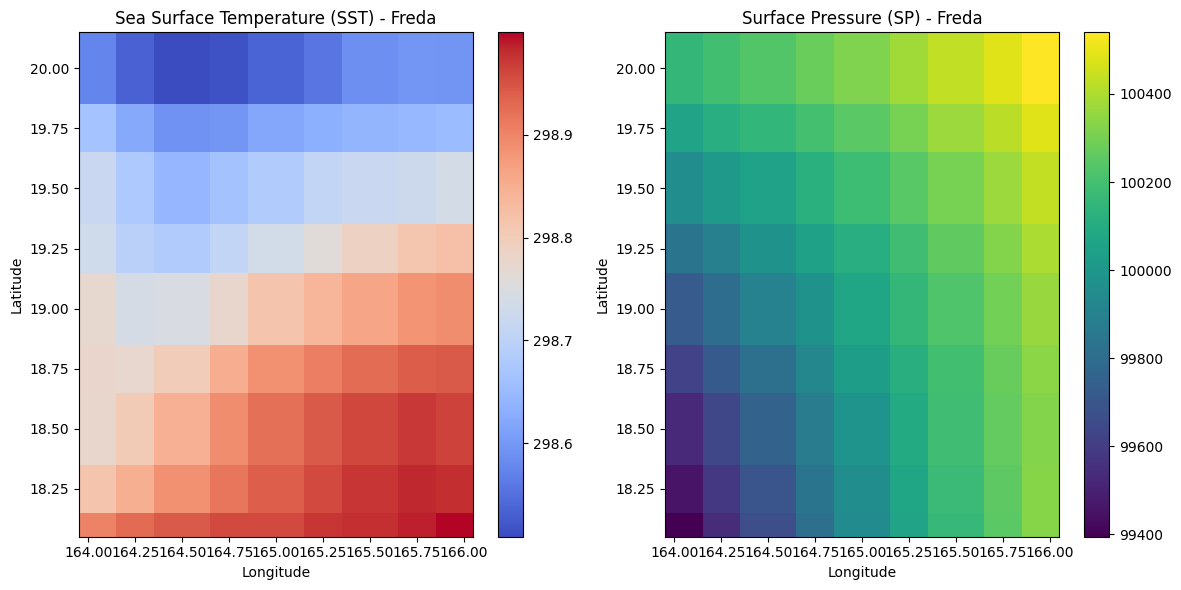

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 加载数据
import json

# 替换为你的文件路径
sp_data_path = '/home/dl392/data/yiwei/typhoon/data_preprocess/sp_data_matrix.json'
sst_data_path = '/home/dl392/data/yiwei/typhoon/data_preprocess/sst_data_matrix.json'

with open(sst_data_path, 'r') as f:
    sst_data = json.load(f)
with open(sp_data_path, 'r') as f:
    sp_data = json.load(f)

# 选择台风案例 "Freda"
example_typhoon = "Freda1981031510"

# 检查是否存在 "Freda" 数据
if example_typhoon not in sst_data or example_typhoon not in sp_data:
    raise ValueError(f"{example_typhoon} 不在数据集中，请确认文件内容。")

# 获取纬度、经度和网格数据
latitude = sst_data[example_typhoon]["latitude_range"]
longitude = sst_data[example_typhoon]["longitude_range"]
sst_grid = np.array(sst_data[example_typhoon]["sst_grid"])
sp_grid = np.array(sp_data[example_typhoon]["sp_grid"])

# 定义要展示的中心坐标和范围
center_lat = 19.1  # 可以根据 Freda 的中心坐标调整
center_lon = 165
lat_range = [center_lat - 1, center_lat + 1]
lon_range = [center_lon - 1, center_lon + 1]

# 筛选对应范围的数据
lat_indices = [i for i, lat in enumerate(latitude) if lat_range[0] <= lat <= lat_range[1]]
lon_indices = [i for i, lon in enumerate(longitude) if lon_range[0] <= lon <= lon_range[1]]

# 截取子网格
sst_subgrid = sst_grid[np.ix_(lat_indices, lon_indices)]
sp_subgrid = sp_grid[np.ix_(lat_indices, lon_indices)]
latitude_sub = np.array(latitude)[lat_indices]
longitude_sub = np.array(longitude)[lon_indices]

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 热力图1: SST
c1 = axes[0].pcolormesh(longitude_sub, latitude_sub, sst_subgrid, shading='auto', cmap='coolwarm')
axes[0].set_title('Sea Surface Temperature (SST) - Freda')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
fig.colorbar(c1, ax=axes[0], orientation='vertical')

# 热力图2: Surface Pressure
c2 = axes[1].pcolormesh(longitude_sub, latitude_sub, sp_subgrid, shading='auto', cmap='viridis')
axes[1].set_title('Surface Pressure (SP) - Freda')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
fig.colorbar(c2, ax=axes[1], orientation='vertical')

plt.tight_layout()
plt.savefig("6.png")

In [20]:
import json
import csv

# Load the JSON data
with open('/home/dl392/data/yiwei/typhoon/data_preprocess/sst_data_matrix.json', 'r') as f:
    data = json.load(f)

# Initialize a dictionary to group names
name_groups = {}

# Populate the name_groups dictionary
for key in data:
    # Extract name from the key (e.g., "Vernon1984060716" -> "Vernon")
    name = ''.join([char for char in key if char.isalpha()])
    
    if name not in name_groups:
        name_groups[name] = []
    
    name_groups[name].append(key)

# Initialize a list to keep track of names with "NaN" in their sst_grid
exclude_names = []

# Check each name group for "NaN" in the sst_grid
for name, keys in name_groups.items():
    for key in keys:
        sst_grid = data[key].get('sst_grid', [])
        # Check for "NaN" in any of the sst_grid values
        if any(str(val) == 'nan' for row in sst_grid for val in row):
            exclude_names.append(name)
            break

# Now create a final list of names to include (exclude those with "NaN" in their sst_grid)
included_names = [name for name in name_groups.keys() if name not in exclude_names]

# Save the final list to a CSV file
with open('final_names.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Name'])
    for name in included_names:
        writer.writerow([name])

print("CSV file has been created with the included names.")





CSV file has been created with the included names.


In [2]:
import pandas as pd

# 文件路径
best_track_file = "/data1/dl392/yiwei/typhoon/data_preprocess/best_track_records.csv_p5.csv"
final_names_file = "/data1/dl392/yiwei/typhoon/data_preprocess/final_names.csv"
output_file = "/data1/dl392/yiwei/typhoon/data_preprocess/best_track_records_p6.csv"

# 读取数据
best_track_df = pd.read_csv(best_track_file)
final_names_df = pd.read_csv(final_names_file)

# 获取 Name 列的集合
valid_names = set(final_names_df['Name'])

# 过滤掉不在 Name 列中的行
filtered_best_track_df = best_track_df[best_track_df['Storm Name'].isin(valid_names)]

# 保存结果到新的 CSV 文件
filtered_best_track_df.to_csv(output_file, index=False)

print(f"过滤完成，结果已保存到 {output_file}")


过滤完成，结果已保存到 /data1/dl392/yiwei/typhoon/data_preprocess/best_track_records_p6.csv
